## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть на датасете fashion-mnist
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>

Вариант 2. (сложный)
- реализовать нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>
</ol>

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:72.5% !important; }</style>"))

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D, Activation, MaxPooling2D, BatchNormalization, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers, optimizers
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### AlexNet — свёрточная нейронная сеть для классификации изображений

![image](img/AlexNet-1-1.png)
AlexNet — сверточная нейронная сеть, которая оказала большое влияние на развитие машинного обучения, в особенности — на алгоритмы компьютерного зрения. 

**Особенности AlexNet**
1. Как функция активации используется Relu вместо арктангенса для добавления в модель нелинейности. За счет этого при одинаковой точности метода скорость становится в 6 раз быстрее.
2. Использование дропаута вместо регуляризации решает проблему переобучения. Однако время обучения удваивается с показателем дропаута 0,5.
3. Производится перекрытие объединений для уменьшения размера сети. За счет этого уровень ошибок первого и пятого уровней снижаются до 0,4% и 0,3%, соответственно.

**Архитектура**
![image](img/Capture-12-1.jpg)
AlexNet содержит восемь слоев с весовыми коэффициентами. Первые пять из них сверточные, а остальные три — полносвязные. Выходные данные пропускаются через функцию потерь softmax, которая формирует распределение 1000 меток классов. Сеть максимизирует многолинейную логистическую регрессию, что эквивалентно максимизации среднего по всем обучающим случаям логарифма вероятности правильной маркировки по распределению ожидания. Ядра второго, четвертого и пятого сверточных слоев связаны только с теми картами ядра в предыдущем слое, которые находятся на одном и том же графическом процессоре. Ядра третьего сверточного слоя связаны со всеми картами ядер второго слоя. Нейроны в полносвязных слоях связаны со всеми нейронами предыдущего слоя.

Таким образом, AlexNet содержит 5 сверточных слоев и 3 полносвязных слоя. Relu применяется после каждого сверточного и полносвязного слоя. Дропаут применяется перед первым и вторым полносвязными слоями. Сеть содержит 62,3 миллиона параметров и затрачивает 1,1 миллиарда вычислений при прямом проходе.  Сверточные слои, на которые приходится 6% всех параметров, производят 95% вычислений.

### Загрузка данных

In [4]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


### Изучение датасета

In [5]:
x_train.shape

(50000, 32, 32, 3)

In [6]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [7]:
y_train.shape

(50000, 1)

In [8]:
x_test.shape

(10000, 32, 32, 3)

In [9]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [10]:
y_test.shape

(10000, 1)

### Построение модели

In [11]:
# Normalizing
x_train = x_train / 255
x_test = x_test / 255

# One hot encoding
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

![image](img/models.png)

In [12]:
def plot_model(history): 
    fig, axs = plt.subplots(1, 2, figsize=(16, 5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], 'c') 
    axs[0].plot(history.history['val_accuracy'],'m') 
    axs[0].set_title('Accuracy of epochs')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epochs')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].plot(history.history['val_loss'], 'm') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epochs')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

### Tensorflow with TPU

In [13]:
# import os

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

### Tensorflow with GPU

In [14]:
%tensorflow_version 2.x
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.954295603999995
GPU (s):
0.10409495999999763
GPU speedup over CPU: 28x


### Model - 1

In [15]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

In [16]:
model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [17]:
%%time
history = model.fit(x_train, y_train_cat, epochs=20, validation_data=(x_test, y_test_cat))

Epoch 1/20
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4836 - accuracy: 0.4636 - val_loss: 1.2217 - val_accuracy: 0.5687
Epoch 2/20
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1510 - accuracy: 0.5958 - val_loss: 1.1176 - val_accuracy: 0.6070
Epoch 3/20
1563/1563 [==============================] - 5s 4ms/step - loss: 1.0010 - accuracy: 0.6479 - val_loss: 1.0122 - val_accuracy: 0.6466
Epoch 4/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8872 - accuracy: 0.6900 - val_loss: 0.9560 - val_accuracy: 0.6700
Epoch 5/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7967 - accuracy: 0.7210 - val_loss: 1.0214 - val_accuracy: 0.6502
Epoch 6/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7221 - accuracy: 0.7481 - val_loss: 0.9502 - val_accuracy: 0.6775
Epoch 7/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.6471 - accuracy: 0.7739 - val_loss: 0.9521 - val_accuracy:

In [18]:
score_train = model.evaluate(x_train, y_train_cat, verbose=0)
score_test = model.evaluate(x_test, y_test_cat, verbose=0)

In [19]:
print('Train loss:', score_train[0])
print('Train accuracy:', score_train[1])
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])

Train loss: 0.14131902158260345
Train accuracy: 0.9501000046730042
Test loss: 2.0103654861450195
Test accuracy: 0.6654000282287598


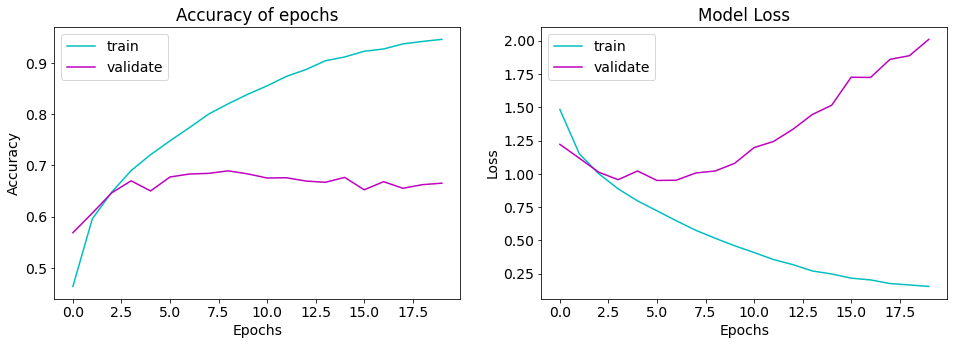

In [20]:
plot_model(history)

### Model - 2

In [21]:
# Add Drop out
model_2 = Sequential([
    Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25), # Drop 25% of the units from the layer
    Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

In [22]:
model_2.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [23]:
%%time
history_2 = model_2.fit(x_train, y_train_cat, epochs=20, validation_data=(x_test, y_test_cat))

Epoch 1/20
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5390 - accuracy: 0.4397 - val_loss: 1.2683 - val_accuracy: 0.5474
Epoch 2/20
1563/1563 [==============================] - 5s 3ms/step - loss: 1.2387 - accuracy: 0.5611 - val_loss: 1.1110 - val_accuracy: 0.6072
Epoch 3/20
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1133 - accuracy: 0.6081 - val_loss: 1.0512 - val_accuracy: 0.6329
Epoch 4/20
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0264 - accuracy: 0.6393 - val_loss: 1.0637 - val_accuracy: 0.6293
Epoch 5/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9617 - accuracy: 0.6647 - val_loss: 0.9624 - val_accuracy: 0.6581
Epoch 6/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9067 - accuracy: 0.6817 - val_loss: 0.9128 - val_accuracy: 0.6821
Epoch 7/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8583 - accuracy: 0.6980 - val_loss: 0.8969 - val_accuracy:

In [24]:
score_train_2 = model_2.evaluate(x_train, y_train_cat, verbose=0)
score_test_2 = model_2.evaluate(x_test, y_test_cat, verbose=0)

In [25]:
print('Train loss:', score_train_2[0])
print('Train accuracy:', score_train_2[1])
print('Test loss:', score_test_2[0])
print('Test accuracy:', score_test_2[1])

Train loss: 0.31446200609207153
Train accuracy: 0.9027400016784668
Test loss: 0.8952844738960266
Test accuracy: 0.7109000086784363


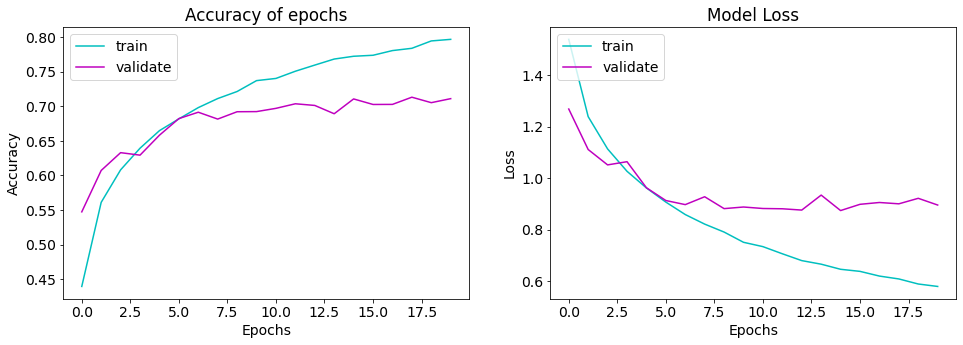

In [26]:
plot_model(history_2)

### Model - 3

In [27]:
# Add More layers with more filters
model_3 = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4), # Drop 40% of the units from the layer
    
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax')
])

In [28]:
model_3.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [29]:
%%time
history_3 = model_3.fit(x_train, y_train_cat, epochs=50, validation_data=(x_test, y_test_cat))

Epoch 1/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.5868 - accuracy: 0.4132 - val_loss: 1.2258 - val_accuracy: 0.5592
Epoch 2/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1560 - accuracy: 0.5883 - val_loss: 0.9630 - val_accuracy: 0.6589
Epoch 3/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9810 - accuracy: 0.6536 - val_loss: 0.8928 - val_accuracy: 0.6887
Epoch 4/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8755 - accuracy: 0.6940 - val_loss: 0.8168 - val_accuracy: 0.7147
Epoch 5/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7909 - accuracy: 0.7196 - val_loss: 0.7850 - val_accuracy: 0.7290
Epoch 6/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7350 - accuracy: 0.7424 - val_loss: 0.7698 - val_accuracy: 0.7366
Epoch 7/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6836 - accuracy: 0.7585 - val_loss: 0.7331 - val_ac

In [30]:
score_train_3 = model_3.evaluate(x_train, y_train_cat, verbose=0)
score_test_3 = model_3.evaluate(x_test, y_test_cat, verbose=0)

In [31]:
print('Train loss:', score_train_3[0])
print('Train accuracy:', score_train_3[1])
print('Test loss:', score_test_3[0])
print('Test accuracy:', score_test_3[1])

Train loss: 0.03466339781880379
Train accuracy: 0.9919400215148926
Test loss: 0.9382410049438477
Test accuracy: 0.7713000178337097


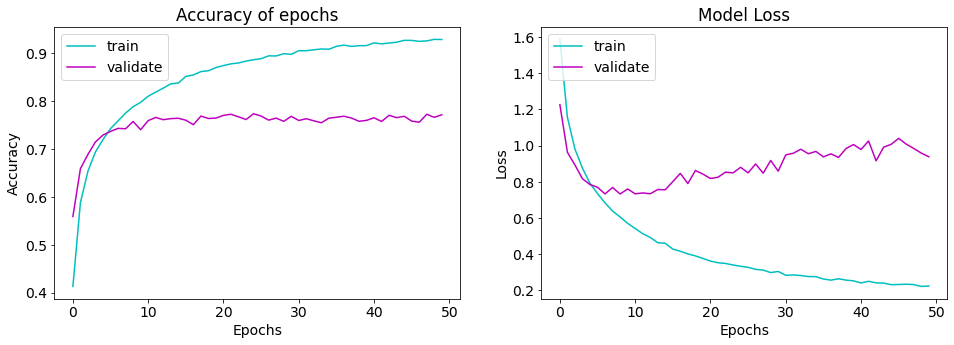

In [32]:
plot_model(history_3)

### Model - 4

In [33]:
# Increased layers and Filters along with Increased dropout
model_4 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2), # Drop 20% of the units from the layer
    
    Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3), # Drop 30% of the units from the layer
    
    Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4), # Drop 40% of the units from the layer
    
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dropout(0.5), # Drop 50% of the units from the layer
    Dense(10, activation='softmax')
])

In [34]:
model_4.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [35]:
%%time
history_4 = model_4.fit(x_train, y_train_cat, epochs=50, validation_data=(x_test, y_test_cat))

Epoch 1/50
1563/1563 [==============================] - 8s 5ms/step - loss: 1.7549 - accuracy: 0.3458 - val_loss: 1.5013 - val_accuracy: 0.4514
Epoch 2/50
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3209 - accuracy: 0.5267 - val_loss: 1.0979 - val_accuracy: 0.6114
Epoch 3/50
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1362 - accuracy: 0.6027 - val_loss: 0.9548 - val_accuracy: 0.6659
Epoch 4/50
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0215 - accuracy: 0.6431 - val_loss: 0.8280 - val_accuracy: 0.7189
Epoch 5/50
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9543 - accuracy: 0.6683 - val_loss: 0.8223 - val_accuracy: 0.7087
Epoch 6/50
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8995 - accuracy: 0.6879 - val_loss: 0.7536 - val_accuracy: 0.7411
Epoch 7/50
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8666 - accuracy: 0.7008 - val_loss: 0.7342 - val_accuracy:

In [36]:
score_train_4 = model_4.evaluate(x_train, y_train_cat, verbose=0)
score_test_4 = model_4.evaluate(x_test, y_test_cat, verbose=0)

In [37]:
print('Train loss:', score_train_4[0])
print('Train accuracy:', score_train_4[1])
print('Test loss:', score_test_4[0])
print('Test accuracy:', score_test_4[1])

Train loss: 0.3631884753704071
Train accuracy: 0.8737599849700928
Test loss: 0.6219920516014099
Test accuracy: 0.8014000058174133


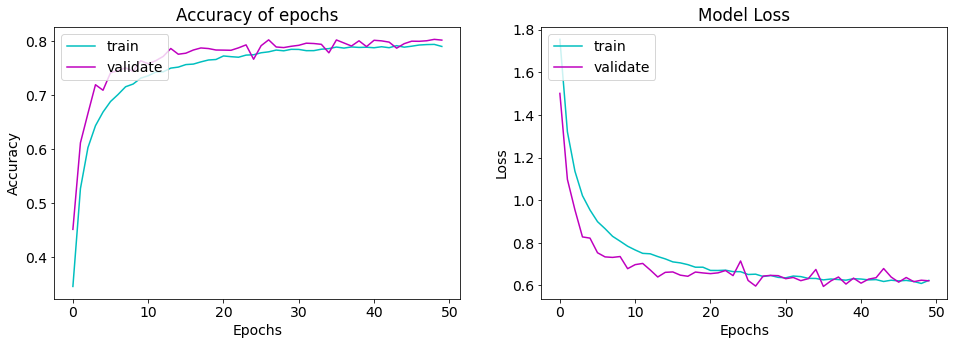

In [38]:
plot_model(history_4)

### Model - 5

In [39]:
# Adding Batch Normalization
model_5 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2), # Drop 20% of the units from the layer
    
    Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3), # Drop 30% of the units from the layer
    
    Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4), # Drop 40% of the units from the layer
    
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.5), # Drop 50% of the units from the layer
    Dense(10, activation='softmax')
])

In [40]:
model_5.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [41]:
%%time
history_5 = model_5.fit(x_train, y_train_cat, epochs=50, validation_data=(x_test, y_test_cat))

Epoch 1/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.6047 - accuracy: 0.4447 - val_loss: 1.1114 - val_accuracy: 0.6093
Epoch 2/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0690 - accuracy: 0.6233 - val_loss: 0.8685 - val_accuracy: 0.6898
Epoch 3/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9032 - accuracy: 0.6860 - val_loss: 0.7397 - val_accuracy: 0.7368
Epoch 4/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7898 - accuracy: 0.7253 - val_loss: 0.7953 - val_accuracy: 0.7286
Epoch 5/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7175 - accuracy: 0.7547 - val_loss: 0.6072 - val_accuracy: 0.7899
Epoch 6/50
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6597 - accuracy: 0.7755 - val_loss: 0.7047 - val_accuracy: 0.7610
Epoch 7/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.6119 - accuracy: 0.7919 - val_loss: 0.5726 - val_accurac

In [42]:
score_train_5 = model_5.evaluate(x_train, y_train_cat, verbose=0)
score_test_5 = model_5.evaluate(x_test, y_test_cat, verbose=0)

In [43]:
print('Train loss:', score_train_5[0])
print('Train accuracy:', score_train_5[1])
print('Test loss:', score_test_5[0])
print('Test accuracy:', score_test_5[1])

Train loss: 0.03851916268467903
Train accuracy: 0.9906600117683411
Test loss: 0.423357218503952
Test accuracy: 0.8694999814033508


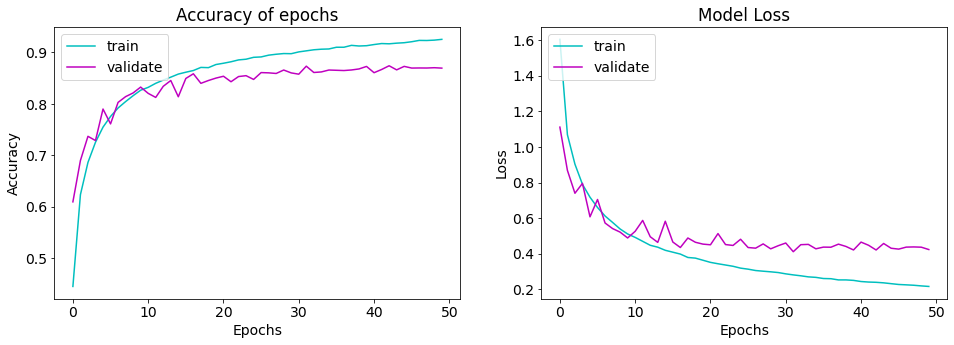

In [44]:
plot_model(history_5)

### Model - 6(Image Augmentation for Deep Learning)  
![image](img/cats-data-augmentation.jpg)

In [45]:
model_6 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2), # Drop 20% of the units from the layer
    
    Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3), # Drop 30% of the units from the layer
    
    Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4), # Drop 40% of the units from the layer
    
    Flatten(),
    Dense(256, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.5), # Drop 50% of the units from the layer
    Dense(10, activation='softmax')
])

In [46]:
model_6.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [51]:
# data augmentation
datagen = ImageDataGenerator(
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False
                            )
datagen.fit(x_train)

In [70]:
%%time
history_6 = model_6.fit_generator(datagen.flow(x_train, y_train_cat, batch_size = 64),
                                 validation_data = (x_test, y_test_cat),
                                 steps_per_epoch = x_train.shape[0] // 64, 
                                 epochs = 50)

Epoch 1/50
781/781 [==============================] - 25s 32ms/step - loss: 0.3804 - accuracy: 0.8682 - val_loss: 0.3757 - val_accuracy: 0.8734
Epoch 2/50
781/781 [==============================] - 25s 32ms/step - loss: 0.3766 - accuracy: 0.8716 - val_loss: 0.3941 - val_accuracy: 0.8670
Epoch 3/50
781/781 [==============================] - 25s 31ms/step - loss: 0.3727 - accuracy: 0.8711 - val_loss: 0.3952 - val_accuracy: 0.8693
Epoch 4/50
781/781 [==============================] - 25s 32ms/step - loss: 0.3675 - accuracy: 0.8726 - val_loss: 0.4481 - val_accuracy: 0.8549
Epoch 5/50
781/781 [==============================] - 25s 32ms/step - loss: 0.3688 - accuracy: 0.8730 - val_loss: 0.3974 - val_accuracy: 0.8709
Epoch 6/50
781/781 [==============================] - 25s 32ms/step - loss: 0.3683 - accuracy: 0.8746 - val_loss: 0.3622 - val_accuracy: 0.8796
Epoch 7/50
781/781 [==============================] - 25s 32ms/step - loss: 0.3639 - accuracy: 0.8754 - val_loss: 0.3506 - val_accuracy:

In [81]:
score_train_6 = model_6.evaluate(x_train, y_train_cat, verbose=0)
score_test_6 = model_6.evaluate(x_test, y_test_cat, verbose=0)

In [82]:
print('Train loss:', score_train_6[0])
print('Train accuracy:', score_train_6[1])
print('Test loss:', score_test_6[0])
print('Test accuracy:', score_test_6[1])

Train loss: 0.19769003987312317
Train accuracy: 0.9303600192070007
Test loss: 0.3635890781879425
Test accuracy: 0.8823000192642212


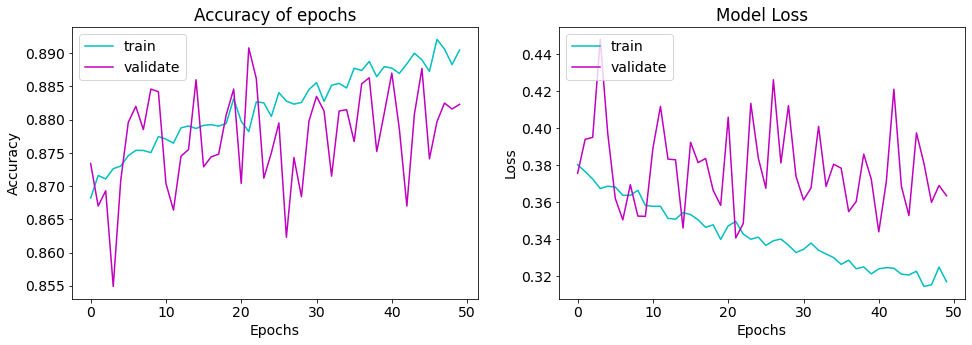

In [83]:
plot_model(history_6)

### Results

In [93]:
results = pd.DataFrame({'model_1': (score_train[1], score_test[1], score_train[0], score_test[0]), 
                        'model_2': (score_train_2[1], score_test_2[1], score_train_2[0], score_test_2[0]), 
                        'model_3': (score_train_3[1], score_test_3[1], score_train_3[0], score_test_3[0]), 
                        'model_4': (score_train_4[1], score_test_4[1], score_train_4[0], score_test_4[0]), 
                        'model_5': (score_train_5[1], score_test_5[1], score_train_5[0], score_test_5[0]), 
                        'model_6': (score_train_6[1], score_test_6[1], score_train_6[0], score_test_6[0])}).T
results.columns=['Train accuracy', 'Test accuracy', 'Train loss', 'Test loss']

results

,Train accuracy,Test accuracy,Train loss,Test loss
model_1,0.95010,0.66540,0.14132,2.01037
model_2,0.90274,0.71090,0.31446,0.89528
model_3,0.99194,0.77130,0.03466,0.93824
model_4,0.87376,0.80140,0.36319,0.62199
model_5,0.99066,0.86950,0.03852,0.42336
model_6,0.93036,0.88230,0.19769,0.36359


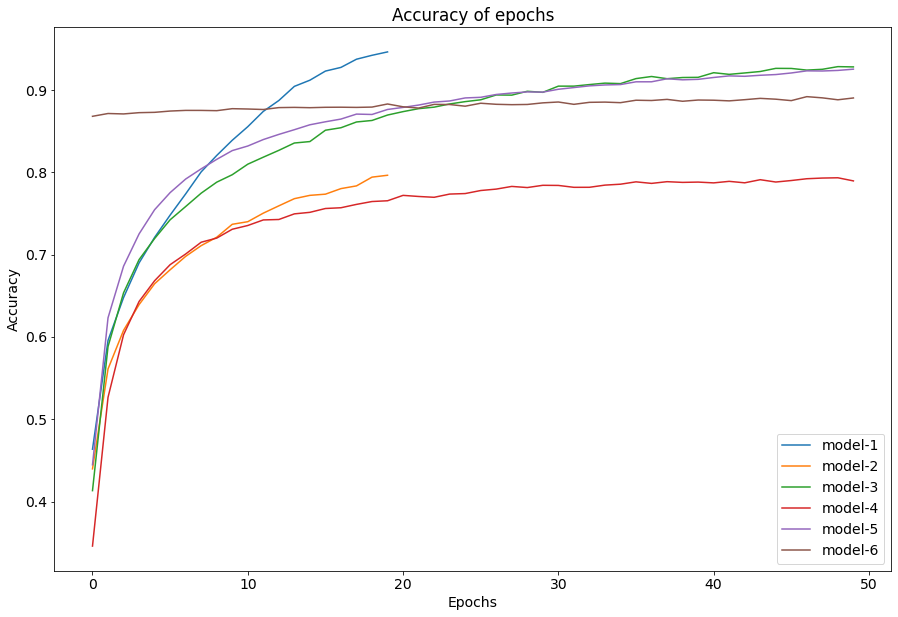

In [88]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['accuracy'], label='model-1')
plt.plot(history_2.history['accuracy'], label='model-2')
plt.plot(history_3.history['accuracy'], label='model-3')
plt.plot(history_4.history['accuracy'], label='model-4')
plt.plot(history_5.history['accuracy'], label='model-5')
plt.plot(history_6.history['accuracy'], label='model-6')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of epochs')
plt.show()

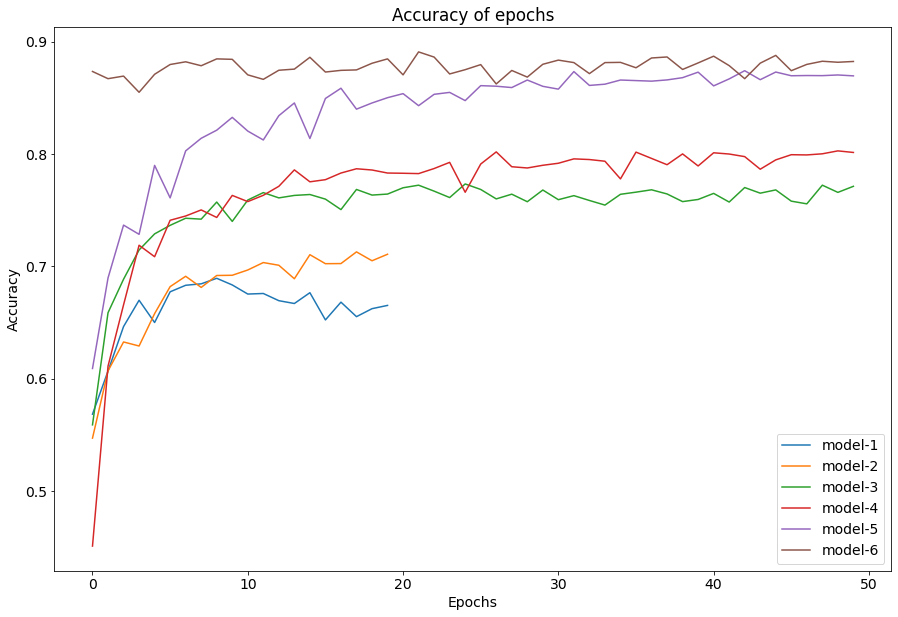

In [89]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['val_accuracy'], label='model-1')
plt.plot(history_2.history['val_accuracy'], label='model-2')
plt.plot(history_3.history['val_accuracy'], label='model-3')
plt.plot(history_4.history['val_accuracy'], label='model-4')
plt.plot(history_5.history['val_accuracy'], label='model-5')
plt.plot(history_6.history['val_accuracy'], label='model-6')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of epochs')
plt.show()

In [9]:
# model_6.summary()

При реализации и последующем анализе сверточных моделей для текущего набора данных - cifar10 в стиле AlexNet, мы наблюдаем, что в простых сетях, при небольшой глубине, сложности и ширине, на выходе получаем весьма низкую точность, а также присутствует явный эффект переобучения. Усложняя модель, мы наблюдаем обратное, увеличение точности и уменьшение эффекта переобучения(при добавлении слоя Dropout), но при всём этом существенно возрастает время обработки датасета, особенно если производить обучение на CPU. Прирост точности, производительности и и стабильности даёт метод регуляризации сети - Batch normalization. Суть данного метода заключается в том, что некоторым слоям нейронной сети на вход подаются данные, предварительно обработанные и имеющие нулевое математическое ожидание и единичную дисперсию. Ещё отдельно можно отметить технологию Image Augmentation for Deep Learning, при использовании которой создаются обучающие изображения с помощью различных способов обработки или комбинации множественной обработки, такой как случайное вращение, сдвиги, сдвиг и переворот и т.п.